# Generator on the fly

In [1]:
from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import os
import glob
import skimage.transform as trans
import os
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [2]:
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 933120000

In [3]:
TRAIN_DATA_DIR = "/Users/guidosidoni/Documents/ACDC/Data/Train/"
VAL_DATA_DIR = "/Users/guidosidoni/Documents/ACDC/LabUBA/dlmi-uba/practica3/data/Val/"
TEST_IMAGES_DIR = "/Users/guidosidoni/Documents/ACDC/LabUBA/dlmi-uba/practica3/data/Test/Images/"
TEST_LABELS_DIR = "/Users/guidosidoni/Documents/ACDC/LabUBA/dlmi-uba/practica3/data/Test/Labels/"

In [144]:
def trainGenerator(batch_size, train_path, image_folder, mask_folder, aug_dict, image_color_mode = "rgb",
                    mask_color_mode = "grayscale",image_save_prefix  = "image", mask_save_prefix  = "mask",
                    save_to_dir = None, target_size = (2048,2048), seed = 1, num_croping=10):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    for (img_raw, mask_raw) in train_generator:
        for crop in range(1,num_croping):
            img, mask = random_crop(img_raw, mask_raw, (200, 200))
            img, mask = adjustData(img,mask)
            yield (img, mask)

In [145]:
def random_crop(img, mask, random_crop_size):
    # Note: image_data_format is 'channel_last'
    #assert img.shape[2] == 3 
    
    height, width = img.shape[1], img.shape[2]
    
    #dy y dx son las dimensiones del patche
    dy, dx = random_crop_size

    #x e y son el punto de inicio del patche
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    print(img.shape)
    
    image_patch = img[:, y:(y+dy), x:(x+dx), :]
    mask_patch = mask[:, y:(y+dy), x:(x+dx), :]
    return (image_patch, mask_patch)

In [146]:
def adjustData(img,mask):
    img = img / 255.
    #mask = mask / 255.
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img, mask)


In [147]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')

In [148]:
myGenerator = trainGenerator(20,
                             TRAIN_DATA_DIR,
                             'image',
                             'label',
                             data_gen_args,
                             save_to_dir = None)

In [161]:
#you will see 60 transformed images and their masks in data/membrane/train/aug
num_batch = 20
for i,batch in enumerate(myGenerator):
    if(i >= num_batch):
        break

(4, 2048, 2048, 3)
(4, 2048, 2048, 3)
(4, 2048, 2048, 3)
(4, 2048, 2048, 3)
(4, 2048, 2048, 3)
(4, 2048, 2048, 3)
(4, 2048, 2048, 3)
(4, 2048, 2048, 3)
(4, 2048, 2048, 3)
(4, 2048, 2048, 3)
(4, 2048, 2048, 3)
(4, 2048, 2048, 3)
(4, 2048, 2048, 3)
(4, 2048, 2048, 3)
(4, 2048, 2048, 3)
(4, 2048, 2048, 3)
(4, 2048, 2048, 3)
(4, 2048, 2048, 3)
(4, 2048, 2048, 3)
(4, 2048, 2048, 3)
(4, 2048, 2048, 3)


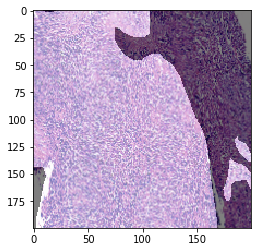

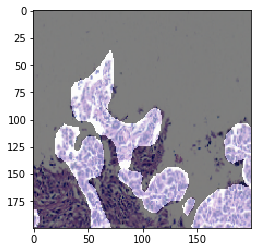

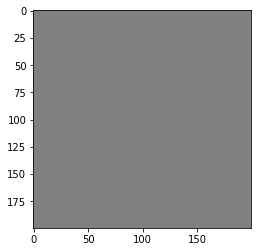

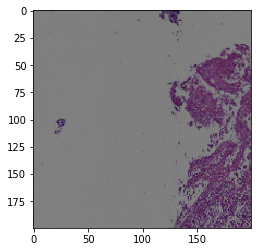

In [162]:
for i in range(batch[0].shape[0]):
    plt.imshow(batch[0][i][:,:,:])
    plt.imshow(batch[1][i][:,:,0] * 250, cmap='gray', alpha=0.5)
    plt.show()

# Generator on the hard drive

The strategi here is to open each image and mask at a time, generates N patches of size W, H from it, and save them in the hard drive. Alfterwards, I will be necesary to create a generator, flow_from_directory with data augmentation to feed the U-NET.

In [8]:
def generate_normal_number(value):
    number = -1
    while number < 0 or number > value: 
        number = np.floor(np.random.normal(value/2, value/4))
    return int(number)


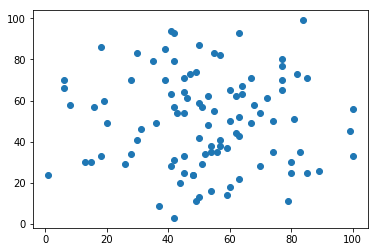

In [270]:
numbers = np.asarray([[generate_normal_number(100), generate_normal_number(100)] for x in range(1,100)])
plt.scatter(numbers[:,0], numbers[:,1])

In [346]:
from PIL import Image
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt

im = Image.open(TRAIN_DATA_DIR + 'image/10_img_patch.tif')
mk = Image.open(TRAIN_DATA_DIR + 'label/10_msk_patch.tif')
imarray = numpy.array(im)
mskarray = numpy.array(mk)
im.show()
im.close()
mk.close()

In [326]:
imarray.shape, mskarray[:,:,newaxis].shape

((3160, 5894, 3), (3160, 5894, 1))

In [4]:
from PIL import Image

def random_crop(img, mask, random_crop_size):
    # Note: image_data_format is 'channel_last'
    #assert img.shape[2] == 3 
    
    height, width = img.shape[0], img.shape[1]
    
    #dy y dx son las dimensiones del patche
    dy, dx = random_crop_size

    #x e y son el punto de inicio del patche
    #x = np.random.randint(0, width - dx + 1)
    #y = np.random.randint(0, height - dy + 1)
        
    x = generate_normal_number(width - dx + 1)
    y = generate_normal_number(height - dy + 1)
    
    image_patch = img[y:(y+dy), x:(x+dx), :]
    mask_patch = mask[y:(y+dy), x:(x+dx), :]
    return (image_patch, mask_patch)

def patch_generator(imarray, mskarray, lowermargin=250, numpatches=100, size=[256,256], plot=False, save=True, path=None, imagefolder='', maskfolder='', name=None):
    for i in range(0, numpatches):
        #esto es para evitar que se devuelva una imagen todo blanca
        img_patch = np.asarray(251)
        safetycut = 100
        i = 0
        while img_patch.mean() > lowermargin:
            img_patch, msk_patch = random_crop(imarray, mskarray[:,:,newaxis], size)
            i = i + 1
            if i > safetycut:
                break
    
        if plot:
            plt.imshow(img_patch)
            plt.imshow(msk_patch[:,:,0], cmap='gray', alpha=0.5)
            plt.show()

        if save:
            im = Image.fromarray(img_patch)
            im.save(path + imagefolder + name + 'img_patch' + str(i) + '.tif')
            im.close()
            
            mk = Image.fromarray(msk_patch[:,:,0])
            mk.save(path + maskfolder + name + 'msk_patch' + str(i) + '.tif')
            mk.close()

In [9]:
from PIL import Image
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
import glob
import re

TRAIN_DATA_DIR = '/Volumes/AllShare/allimages/'
patch_size = 256

for file in glob.glob(TRAIN_DATA_DIR + 'boxedB/*_img_patch.tif'):
    print(file)
    extract_number = str(re.search('([0-9]+)', file).group(1))
    image_name = extract_number + '_img_patch.tif'
    mask_name = extract_number + '_msk_patch.tif'
    im = Image.open(TRAIN_DATA_DIR + 'boxedB/' + image_name)
    mk = Image.open(TRAIN_DATA_DIR + 'boxedB/' + mask_name)
    imarray = np.array(im)
    mskarray = np.array(mk)
    
    tamano = mskarray.shape
    numpatches = int(np.floor((tamano[0] * tamano[1]) / 2 / (patch_size * patch_size)))
    print('Patches a generar: {}'.format(numpatches))
    patch_generator(imarray, 
                    mskarray,
                    size=[patch_size, patch_size],
                    lowermargin= 220,
                    numpatches=numpatches, 
                    path=TRAIN_DATA_DIR, 
                    imagefolder='image/', 
                    maskfolder='label/', 
                    name='img'+extract_number)
    im.close()
    mk.close()

/Volumes/AllShare/allimages/boxedB/1016_img_patch.tif
Patches a generar: 624
/Volumes/AllShare/allimages/boxedB/1017_img_patch.tif
Patches a generar: 1745
/Volumes/AllShare/allimages/boxedB/1018_img_patch.tif
Patches a generar: 2058
/Volumes/AllShare/allimages/boxedB/1019_img_patch.tif
Patches a generar: 2018
/Volumes/AllShare/allimages/boxedB/1020_img_patch.tif
Patches a generar: 677
/Volumes/AllShare/allimages/boxedB/1021_img_patch.tif
Patches a generar: 803
/Volumes/AllShare/allimages/boxedB/1022_img_patch.tif
Patches a generar: 577
/Volumes/AllShare/allimages/boxedB/1023_img_patch.tif
Patches a generar: 280
/Volumes/AllShare/allimages/boxedB/1024_img_patch.tif
Patches a generar: 96
/Volumes/AllShare/allimages/boxedB/1025_img_patch.tif
Patches a generar: 356
/Volumes/AllShare/allimages/boxedB/1026_img_patch.tif
Patches a generar: 295
/Volumes/AllShare/allimages/boxedB/1027_img_patch.tif
Patches a generar: 2526
/Volumes/AllShare/allimages/boxedB/1028_img_patch.tif
Patches a generar: 

In [11]:
from PIL import Image
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
import glob
import re

TRAIN_DATA_DIR = '/Volumes/AllShare/allimages/'
patch_size = 256

for file in glob.glob(TRAIN_DATA_DIR + 'boxedC/*_img_patch.tif'):
    print(file)
    extract_number = str(re.search('([0-9]+)', file).group(1))
    image_name = extract_number + '_img_patch.tif'
    mask_name = extract_number + '_msk_patch.tif'
    im = Image.open(TRAIN_DATA_DIR + 'boxedC/' + image_name)
    mk = Image.open(TRAIN_DATA_DIR + 'boxedC/' + mask_name)
    imarray = np.array(im)
    mskarray = np.array(mk)
    
    tamano = mskarray.shape
    numpatches = int(np.floor((tamano[0] * tamano[1]) / 2 / (patch_size * patch_size)))
    print('Patches a generar: {}'.format(numpatches))
    patch_generator(imarray, 
                    mskarray,
                    size=[patch_size, patch_size],
                    lowermargin= 220,
                    numpatches=numpatches, 
                    path=TRAIN_DATA_DIR, 
                    imagefolder='imageVal/', 
                    maskfolder='labelVal/', 
                    name='img'+extract_number)
    im.close()
    mk.close()

/Volumes/AllShare/allimages/boxedC/101_img_patch.tif
Patches a generar: 1718
/Volumes/AllShare/allimages/boxedC/102_img_patch.tif
Patches a generar: 3085
/Volumes/AllShare/allimages/boxedC/103_img_patch.tif
Patches a generar: 3772
/Volumes/AllShare/allimages/boxedC/104_img_patch.tif
Patches a generar: 3473
/Volumes/AllShare/allimages/boxedC/105_img_patch.tif
Patches a generar: 1282
/Volumes/AllShare/allimages/boxedC/106_img_patch.tif
Patches a generar: 3057
/Volumes/AllShare/allimages/boxedC/107_img_patch.tif
Patches a generar: 2381
/Volumes/AllShare/allimages/boxedC/108_img_patch.tif
Patches a generar: 1389
/Volumes/AllShare/allimages/boxedC/109_img_patch.tif
Patches a generar: 624
/Volumes/AllShare/allimages/boxedC/1010_img_patch.tif
Patches a generar: 540
/Volumes/AllShare/allimages/boxedC/1011_img_patch.tif
Patches a generar: 4294
/Volumes/AllShare/allimages/boxedC/1012_img_patch.tif
Patches a generar: 704
/Volumes/AllShare/allimages/boxedC/1013_img_patch.tif
Patches a generar: 136